# Let's Train Mobile LLM



### Configure the machine and install packages


In [12]:
from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on colab
fatal: destination path 'jaxpt' already exists and is not an empty directory.
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.


In [13]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/content/jaxpt/src


In [14]:
import os
import warnings

import jax
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Makes sure the matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.6
Available devices: 1
using gpu
782 µs ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Initialize the Mobile-LLM model and perform a sanity check

In [15]:
from flax import nnx

from jaxpt.infer import generate_completions
from jaxpt.models import Mobile_LLM, MobileLLM_Config
from jaxpt.utils import count_params


key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = MobileLLM_Config(dtype=jnp.bfloat16, \
                    vocab_size=49152,
                    n_embed=576,
                    n_head=9,
                    n_kv_head=3,
                    n_mlp_hidden=1536,
                    sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)
m = Mobile_LLM(config, rngs)

#m = load_checkpoint("run_20250311_uqdwjq", 5600)
graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
total_params = count_params(m)

print(f"Parameter Count: {total_params:,}")
nnx.display(state)

#completions = generate_completions()
#for completion in completions:
#print(completion)

Parameter Count: 134,515,008


### Configure Training Run

In [16]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "colab":
  output_dir = Path().absolute().parent
elif platform == "cuda":
  output_dir = Path("/home/ubuntu/gpt2-train") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent # Local setup

# Create checkpoint dir
checkpoint_dir = output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

# Create log dir
log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

Run: run_20250503_topolm
Checkpoint directory: /checkpoints
Log directory: /logs


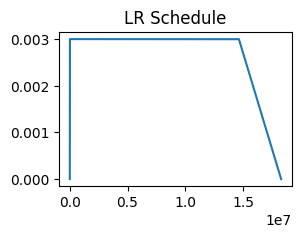

weight decay param count: 134,479,872
tokens/batch: 32,768
block size: 2048
sub-batch size: 16
no. gradient accumulation steps: 1
effective batch size per device:  16
effective batch size: 16
max steps: 18,310,546


In [17]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**15 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 16
  T: int = 2048
  max_steps: int = int((600e9) // (2**15))
  max_lr: float = 3e-3
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 5000
  print_interval: int = 100
  eval_interval: int = 5000
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T * num_devices) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''
# Set up the optimizer
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - 0.8 * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < 0.8 * trconf.max_steps, trconf.max_lr, cooldown_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ trapezoidal_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)

tx = optax.chain(
    #optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(trapezoidal_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask),
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"sub-batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB)
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB * num_devices}")
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [18]:
import os

from jaxpt.dataloaders import HuggingfaceDataLoader

train_dl = HuggingfaceDataLoader(batch_size=trconf.mB,
                                 block_size=trconf.T,
                                 device_rank=num_devices,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=1000,
                                 streaming=True)

Initializing tokenizer HuggingFaceTB/SmolLM-135M


Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/234 [00:00<?, ?it/s]

HuggingfaceDataLoader initialized:
------------------------
label:          train
shards:         0
shard size:     2,066
batch size:     16
block size:     2048
device rank:    1
------------------------


In [19]:
from jaxpt.utils import append_to_csv

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "norm", "time", "tokens_processed", "tokens_per_sec"])
step = 0

0 | lr: 6.00e-07 | loss: 10.9103 | time: 43142.33ms | tokens processed: 32,768 | tok/sec: 759.53
Evaluation TBD
100 | lr: 6.06e-05 | loss: 8.1800 | time: 576.76ms | tokens processed: 3,309,568 | tok/sec: 56,813.64
200 | lr: 1.21e-04 | loss: 7.1025 | time: 523.03ms | tokens processed: 6,586,368 | tok/sec: 62,650.83
300 | lr: 1.81e-04 | loss: 6.6548 | time: 553.90ms | tokens processed: 9,863,168 | tok/sec: 59,158.72
Received KeyboardInterrupt. Exiting...


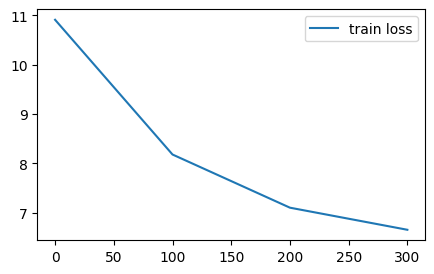

In [20]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.train import parallel_train_step

m.train()
try:
  while step < trconf.max_steps:
    start = time.time()
    batch, target = train_dl()
    avg_loss, avg_grads = parallel_train_step(m, optimizer, batch, target)
    avg_loss.block_until_ready()
    # compute stats
    avg_loss = jnp.float32(avg_loss[0])
    lr = trapezoidal_schedule(step)
    norm = 0 # norm[0]|
    iter_time = time.time() - start
    sub_step_time = iter_time / trconf.grad_accumulation_steps
    tokens_per_sec = num_devices * trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
    tokens_processed = (step+1) * num_devices * trconf.grad_accumulation_steps * trconf.mB * trconf.T

    if step % trconf.print_interval == 0:
      train_losses.append((step, avg_loss))
      append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, norm, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | loss: {avg_loss:0.4f} | time: {iter_time*1000:0.2f}ms | tokens processed: {tokens_processed:,} | tok/sec: {tokens_per_sec:,.2f}") #, end="\r")
    if step % trconf.eval_interval == 0:
      print("Evaluation TBD")
      #save_checkpoint(m, run_dirname, step)
    step += 1

except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

plt.figure(figsize=(5, 3))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.legend()
plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()
